# Symptom Analyzer: Disease Prediction
A compact ML-based system for predicting diseases from symptoms.

This notebook demonstrates:
1. Creating a dataset of symptoms and diseases
2. Training ML models (Naive Bayes, Random Forest)
3. Analyzing symptoms with an interactive interface

In [6]:
# Setup
import pandas as pd, numpy as np, os, re, warnings, joblib
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from IPython.display import display

warnings.filterwarnings('ignore')
os.makedirs('data', exist_ok=True)
os.makedirs('models', exist_ok=True)
plt.style.use('ggplot')

# Text preprocessing
STOPWORDS = {'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while',
             'of', 'at', 'by', 'for', 'with', 'about', 'between', 'into', 'through',
             'during', 'before', 'after', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off'}

def preprocess_text(text):
    '''Clean text by removing stopwords and punctuation'''
    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    return ' '.join(token for token in text.split() if token not in STOPWORDS)

Dataset: 24 samples, 8 diseases


,Symptoms,Disease,Processed_Symptoms
0,fever headache cough,Common Cold,fever headache cough
1,mild fever runny nose sore throat,Common Cold,mild fever runny nose sore throat
2,cough congestion sneezing,Common Cold,cough congestion sneezing


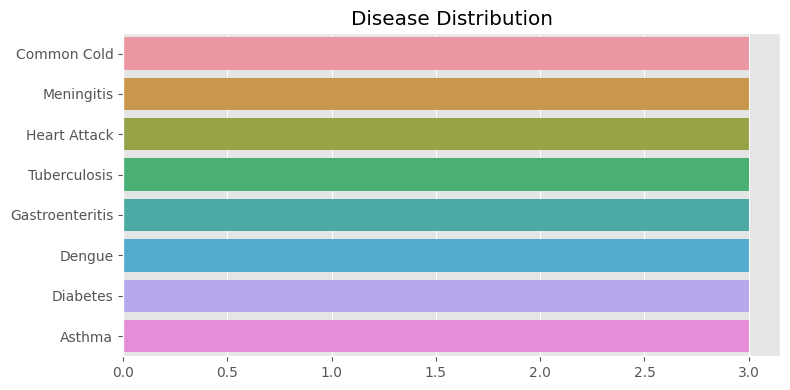

Naive Bayes accuracy: 25.00%
Random Forest accuracy: 25.00%


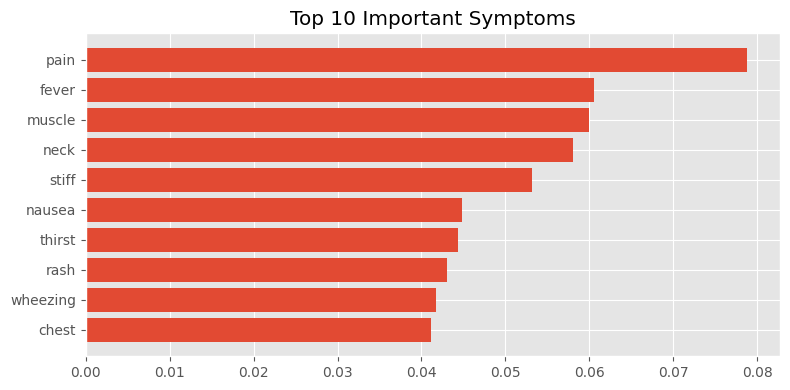

In [7]:
# Create dataset and train models
# Sample data
data = '''Symptoms,Disease
fever headache cough,Common Cold
mild fever runny nose sore throat,Common Cold
cough congestion sneezing,Common Cold
high fever severe headache stiff neck,Meningitis
stiff neck fever vomiting confusion,Meningitis
headache fever stiff neck rash,Meningitis
chest pain shortness of breath sweating,Heart Attack
pain radiating to arm jaw neck,Heart Attack
chest pressure nausea cold sweat,Heart Attack
fatigue weight loss night sweats cough,Tuberculosis
coughing blood chest pain fever,Tuberculosis
night sweats fever persistent cough,Tuberculosis
abdominal pain diarrhea nausea vomiting,Gastroenteritis
stomach cramps watery diarrhea,Gastroenteritis
nausea vomiting fever diarrhea,Gastroenteritis
fever rash joint pain muscle pain,Dengue
high fever headache pain behind eyes,Dengue
muscle joint pain rash vomiting,Dengue
frequent urination excessive thirst hunger,Diabetes
increased thirst frequent urination fatigue,Diabetes
tingling hands feet excessive thirst,Diabetes
wheezing shortness of breath chest tightness,Asthma
shortness of breath wheezing coughing,Asthma
chest tightness difficulty breathing,Asthma'''

# Create, load and preprocess
with open('data/symptom_disease.csv', 'w') as f:
    f.write(data)
df = pd.read_csv('data/symptom_disease.csv')
df['Processed_Symptoms'] = df['Symptoms'].apply(preprocess_text)

print(f"Dataset: {len(df)} samples, {df['Disease'].nunique()} diseases")
display(df.head(3))

# Plot disease distribution
plt.figure(figsize=(8, 4))
disease_counts = df['Disease'].value_counts()
sns.barplot(x=disease_counts.values, y=disease_counts.index)
plt.title('Disease Distribution')
plt.tight_layout()
plt.show()

# Feature extraction and training
vectorizer = TfidfVectorizer(max_features=100)
X = vectorizer.fit_transform(df['Processed_Symptoms'])
le = LabelEncoder()
y = le.fit_transform(df['Disease'])

# Split with minimum test size for stratification (at least one sample per class)
# We'll use 30% test size to ensure enough samples per class
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train models
nb_model = MultinomialNB(alpha=0.5)
nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)
nb_acc = accuracy_score(y_test, nb_pred)

rf_model = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)

print(f"Naive Bayes accuracy: {nb_acc:.2%}")
print(f"Random Forest accuracy: {rf_acc:.2%}")

# Visualize feature importance
feature_names = vectorizer.get_feature_names_out()
indices = np.argsort(rf_model.feature_importances_)[-10:]
plt.figure(figsize=(8, 4))
plt.barh(range(len(indices)), rf_model.feature_importances_[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.title('Top 10 Important Symptoms')
plt.tight_layout()
plt.show()

# Store models for prediction
models = {'nb': nb_model, 'rf': rf_model}


Testing prediction with examples:
Analyzing: 'fever headache cough'
Results:
  Naive Bayes: Meningitis (34.42%, Low confidence)
  Random Forest: Meningitis (27.23%, Low confidence)
FINAL: Meningitis (30.83%, Low confidence)


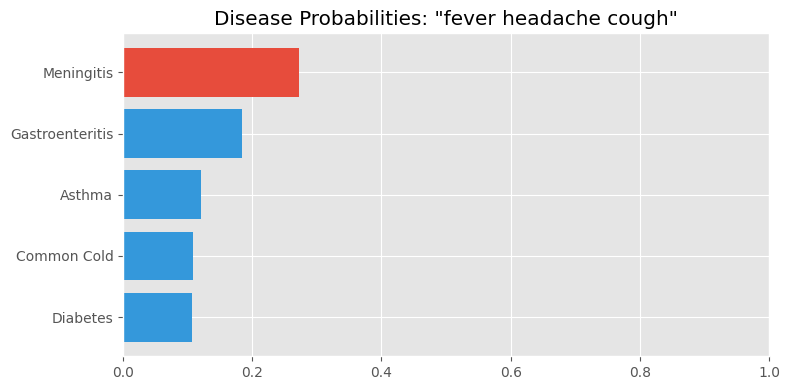

----------------------------------------
Analyzing: 'chest pain shortness of breath'
Results:
  Naive Bayes: Asthma (38.65%, Low confidence)
  Random Forest: Heart Attack (28.75%, Low confidence)
FINAL: Heart Attack (28.75%, Low confidence)


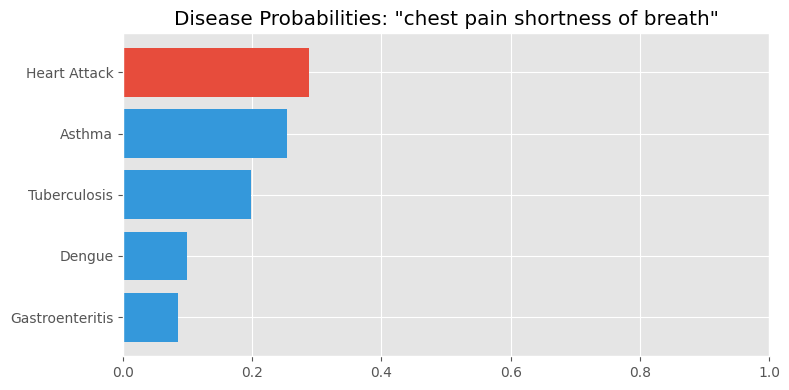

----------------------------------------
Models saved to 'models/' directory


In [8]:
# Symptom analysis function
def predict_disease(symptoms, vectorizer=vectorizer, models=models, le=le):
    '''Predict disease based on symptoms'''
    print(f"Analyzing: '{symptoms}'")
    
    # Process and predict
    X = vectorizer.transform([preprocess_text(symptoms)])
    results = []
    
    # Get predictions from models
    nb_proba = models['nb'].predict_proba(X)[0]
    nb_idx = np.argsort(nb_proba)[-1]
    nb_disease = le.inverse_transform([nb_idx])[0]
    nb_conf = nb_proba[nb_idx]
    results.append((nb_disease, nb_conf, "Naive Bayes"))
    
    rf_proba = models['rf'].predict_proba(X)[0]
    rf_idx = np.argsort(rf_proba)[-1]
    rf_disease = le.inverse_transform([rf_idx])[0]
    rf_conf = rf_proba[rf_idx]
    results.append((rf_disease, rf_conf, "Random Forest"))
    
    # Final prediction (voting)
    predictions = [r[0] for r in results]
    final_pred = max(set(predictions), key=predictions.count)
    avg_conf = sum(r[1] for r in results if r[0] == final_pred) / sum(1 for r in results if r[0] == final_pred)
    confidence_level = "High" if avg_conf >= 0.7 else "Medium" if avg_conf >= 0.4 else "Low"
    
    # Display results
    print("Results:")
    for disease, conf, model in results:
        conf_level = "High" if conf >= 0.7 else "Medium" if conf >= 0.4 else "Low"
        print(f"  {model}: {disease} ({conf:.2%}, {conf_level} confidence)")
    
    print(f"FINAL: {final_pred} ({avg_conf:.2%}, {confidence_level} confidence)")
    
    # Visualize top diseases
    disease_names = le.classes_
    probs = rf_proba
    sorted_idx = np.argsort(probs)
    top_diseases = [disease_names[i] for i in sorted_idx[-5:]]
    top_probs = [probs[i] for i in sorted_idx[-5:]]
    
    plt.figure(figsize=(8, 4))
    colors = ['#3498db'] * 4 + ['#e74c3c']  # Highlight the most probable
    plt.barh(top_diseases, top_probs, color=colors)
    plt.title(f'Disease Probabilities: "{symptoms}"')
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.show()
    
    return final_pred, confidence_level

# Test examples
print("Testing prediction with examples:")
for symptoms in ["fever headache cough", "chest pain shortness of breath"]:
    predict_disease(symptoms)
    print("-" * 40)

# Save models
joblib.dump(vectorizer, 'models/vectorizer.pkl')
joblib.dump(nb_model, 'models/naive_bayes_model.pkl')
joblib.dump(rf_model, 'models/random_forest_model.pkl')
joblib.dump(le, 'models/label_encoder.pkl')
print("Models saved to 'models/' directory")


In [9]:
# Interactive symptom analyzer
try:
    import ipywidgets as widgets
    from IPython.display import clear_output
    
    # Create widgets
    symptom_input = widgets.Text(
        value='', 
        placeholder='Enter symptoms (e.g., "fever headache")',
        description='Symptoms:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='80%')
    )
    
    output_area = widgets.Output()
    
    def on_button_clicked(b):
        with output_area:
            clear_output()
            symptoms = symptom_input.value.strip()
            if symptoms:
                predict_disease(symptoms)
            else:
                print("Please enter symptoms first.")
    
    # Create and display UI
    predict_button = widgets.Button(
        description='Predict Disease',
        button_style='primary',
        icon='search'
    )
    predict_button.on_click(on_button_clicked)
    
    widgets.HTML(value="<h3>Interactive Symptom Analyzer</h3>")
    display(symptom_input, predict_button, output_area)
    
except ImportError:
    # Simple fallback for environments without widgets
    def interactive_loop():
        while True:
            symptoms = input("Enter symptoms (or 'q' to quit): ").strip()
            if symptoms.lower() in ('q', 'quit'): break
            if symptoms: predict_disease(symptoms)
    
    print("Enter symptoms like 'fever headache' or 'chest pain'")


Text(value='', description='Symptoms:', layout=Layout(width='80%'), placeholder='Enter symptoms (e.g., "fever …

Button(button_style='primary', description='Predict Disease', icon='search', style=ButtonStyle())

Output()